<a href="https://colab.research.google.com/github/evanmacbride/cv_final/blob/main/Preprocess_BOVW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will preprocess the signature image dataset.

First, import libraries and set up environment and global variables.

In [1]:
import cv2 as cv
from google.colab import drive
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

ROOT_PATH = 'drive/My Drive/2021 Spring/CV/Final Project/sign_data/'
MAX_WORDS = 300 # The number of "visual words" to keep in the "dictionary"
#LOAD_MAX_PCT = 0.25 # The percent of images to load and process
LOAD_MAX = 320 # The number of images to load and process

drive.mount('/content/drive')

Mounted at /content/drive


Define functions for later use.

In [2]:
def get_features(img, extractor):
  '''
  Return features (i.e. keypoints and descriptors) from an image using an extractor 
  (i.e. ORB).
  '''
  keypoints, descriptors = extractor.detectAndCompute(img, None)
  return keypoints, descriptors

def get_freq_count(descriptors, algorithm):
  '''
  Return a frequency count for a given list of descriptors and a 
  clustering algorithm.
  '''
  freq_count = np.zeros(len(algorithm.cluster_centers_))
  clusters =  algorithm.predict(descriptors)
  for i in clusters:
      freq_count[i] += 1.0
  return freq_count

def prep_data():
  '''
  Return a list of CV2 image feature frequency counts and a corresponding list 
  of the image's class labels (i.e. forgery or genuine).
  '''
  # Get the class label of each image as described in unique.csv.
  file_info_path = ROOT_PATH + 'unique.csv'
  file_info = pd.read_csv(file_info_path)
  # Get a subset of files so data fits in memory
  #file_info = file_info.sample(frac=LOAD_MAX_PCT,random_state=1)
  filenames = list(file_info.iloc[:320,1])
  classes = list(file_info.iloc[:320,2])

  # Read each image listed in unique.csv, then extract its feature descriptors 
  # using ORB. Assign those features to the nearest "visual word" using KMeans.
  # Now each image can be described by a frequency count of the number of times 
  # each visual word appears.
  orb = cv.ORB_create(nfeatures=1800)
  kmeans = KMeans(n_clusters=MAX_WORDS)
  img_freq_counts = []
  all_descriptors = [] # Use to create KMeans clusters
  img_descriptors = [] # Use to create each image's freq_count
  for filename in filenames:
    img_path = ROOT_PATH + 'sign_data/train/' + filename
    img = cv.imread(img_path, 0)
    keypoints, descriptors = get_features(img, orb)
    del img
    img_descriptors.append(descriptors)
    for descriptor in descriptors:
      all_descriptors.append(descriptor)
  print("Images loaded. Fitting KMeans...")
  kmeans.fit(all_descriptors)
  print("KMeans fit. Getting freq_counts...")
  for desc in img_descriptors:
    freq_count = get_freq_count(desc, kmeans)
    img_freq_counts.append(freq_count)
  return filenames, img_freq_counts, classes

Load some test images and create an ORB extractor.

In [3]:
path = 'drive/My Drive/2021 Spring/CV/Final Project/sign_data'
sign_img = cv.imread(path + '/train/069/12_069.png', 0)
forg_img = cv.imread(path + '/train/069_forg/04_0111069.PNG', 0)

orb = cv.ORB_create(nfeatures=1800)

Use ORB to get features from test images. See what features are detected.

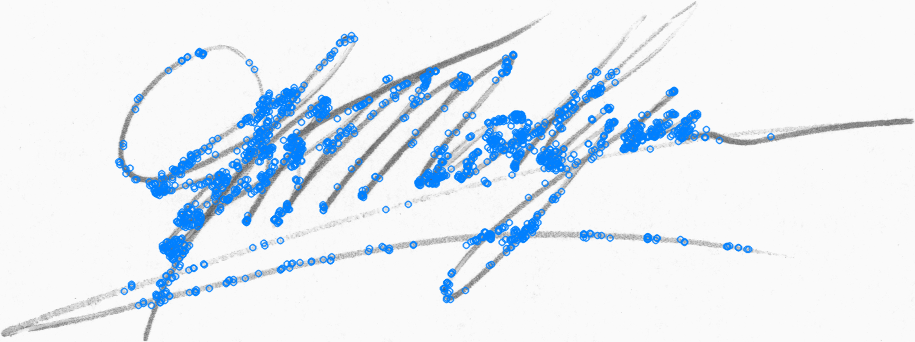

In [4]:
keypoints, descriptors = get_features(sign_img, orb)
keypoint_img = cv.drawKeypoints(sign_img, keypoints, None, color=(255, 127, 0), flags=0)
cv2_imshow(keypoint_img)

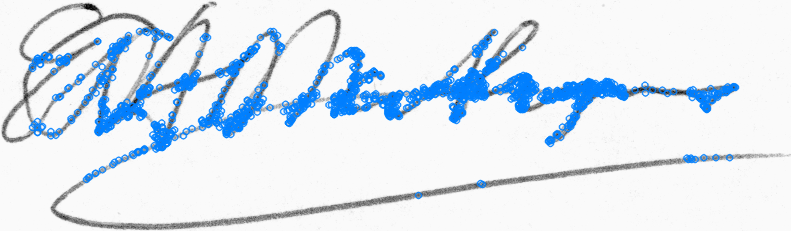

In [5]:
keypoints, descriptors = get_features(forg_img, orb)
keypoint_img = cv.drawKeypoints(forg_img, keypoints, None, color=(255, 127, 0), flags=0)
cv2_imshow(keypoint_img)

Preprocess the data by loading image files, getting their features, getting the closest "visual words" for each feature, compiling frequency counts of those words for each image, and pairing those counts with a class label (i.e. forgery or genuine).

In [6]:
# Get all image frequency counts for visual words and corresponding class labels.
filenames, img_freq_counts, classes = prep_data()
print("Counts == number of classes?")
print(len(img_freq_counts) == len(classes))

Images loaded. Fitting KMeans...
KMeans fit. Getting freq_counts...
Counts == number of classes?
True


Write the preprocessed data to a CSV file.

In [7]:
img_data = pd.DataFrame(img_freq_counts)
img_data['Class'] = classes
img_data['Filename'] = filenames
img_data_path = ROOT_PATH + 'prep_img_data.csv'
img_data.to_csv(img_data_path)

In [8]:
# Check that data was saved properly.
img_data_chk = pd.read_csv(img_data_path)
img_data_chk

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,Class,Filename
0,0,2.0,2.0,7.0,0.0,5.0,4.0,8.0,3.0,6.0,5.0,1.0,7.0,10.0,1.0,1.0,1.0,6.0,1.0,12.0,5.0,9.0,4.0,4.0,6.0,6.0,12.0,18.0,4.0,11.0,5.0,12.0,0.0,5.0,7.0,3.0,4.0,3.0,4.0,4.0,...,6.0,3.0,3.0,4.0,5.0,1.0,4.0,1.0,6.0,8.0,0.0,0.0,10.0,3.0,2.0,3.0,4.0,9.0,4.0,13.0,5.0,9.0,8.0,2.0,9.0,6.0,2.0,3.0,12.0,6.0,5.0,2.0,9.0,7.0,3.0,6.0,6.0,1.0,1,068_forg/03_0113068.PNG
1,1,12.0,8.0,7.0,0.0,3.0,0.0,1.0,1.0,5.0,0.0,7.0,1.0,2.0,8.0,2.0,0.0,0.0,1.0,4.0,1.0,4.0,6.0,1.0,3.0,8.0,8.0,7.0,2.0,2.0,9.0,6.0,0.0,0.0,4.0,6.0,6.0,1.0,7.0,7.0,...,5.0,2.0,6.0,2.0,4.0,5.0,4.0,0.0,7.0,2.0,2.0,0.0,6.0,3.0,3.0,4.0,4.0,6.0,1.0,6.0,9.0,6.0,2.0,12.0,1.0,1.0,4.0,8.0,5.0,2.0,1.0,3.0,5.0,7.0,0.0,6.0,8.0,2.0,1,068_forg/01_0124068.PNG
2,2,2.0,3.0,10.0,0.0,5.0,1.0,2.0,4.0,9.0,4.0,1.0,10.0,3.0,3.0,1.0,3.0,2.0,0.0,5.0,6.0,5.0,2.0,1.0,5.0,3.0,7.0,5.0,1.0,0.0,3.0,2.0,2.0,1.0,7.0,5.0,2.0,5.0,4.0,1.0,...,7.0,1.0,1.0,4.0,2.0,3.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,5.0,2.0,2.0,3.0,3.0,5.0,3.0,1.0,8.0,3.0,6.0,1.0,3.0,8.0,4.0,4.0,4.0,1.0,3.0,6.0,7.0,8.0,4.0,3.0,1,068_forg/02_0124068.PNG
3,3,9.0,2.0,9.0,0.0,10.0,0.0,6.0,2.0,6.0,5.0,5.0,4.0,3.0,5.0,1.0,0.0,8.0,3.0,6.0,6.0,4.0,1.0,1.0,4.0,3.0,8.0,4.0,2.0,7.0,2.0,4.0,2.0,3.0,8.0,3.0,3.0,7.0,4.0,5.0,...,10.0,2.0,6.0,1.0,2.0,8.0,4.0,1.0,7.0,3.0,0.0,0.0,3.0,4.0,7.0,2.0,0.0,2.0,0.0,2.0,4.0,2.0,4.0,7.0,11.0,6.0,4.0,6.0,3.0,0.0,4.0,1.0,6.0,3.0,3.0,2.0,4.0,8.0,1,068_forg/01_0113068.PNG
4,4,3.0,5.0,6.0,1.0,2.0,1.0,5.0,1.0,8.0,2.0,1.0,3.0,3.0,3.0,2.0,0.0,0.0,0.0,3.0,4.0,3.0,5.0,1.0,1.0,2.0,9.0,4.0,0.0,5.0,7.0,3.0,0.0,4.0,4.0,3.0,6.0,2.0,3.0,1.0,...,7.0,2.0,7.0,2.0,1.0,5.0,6.0,0.0,5.0,4.0,0.0,0.0,1.0,13.0,4.0,3.0,1.0,2.0,2.0,4.0,6.0,3.0,7.0,3.0,11.0,5.0,2.0,5.0,4.0,4.0,7.0,2.0,5.0,2.0,4.0,4.0,6.0,4.0,1,068_forg/04_0124068.PNG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,315,6.0,4.0,6.0,0.0,7.0,2.0,2.0,6.0,6.0,6.0,6.0,2.0,12.0,3.0,7.0,2.0,2.0,1.0,4.0,4.0,7.0,3.0,0.0,2.0,6.0,1.0,9.0,4.0,6.0,5.0,9.0,9.0,5.0,4.0,6.0,1.0,5.0,2.0,1.0,...,2.0,1.0,6.0,8.0,5.0,1.0,7.0,0.0,5.0,3.0,0.0,1.0,2.0,1.0,6.0,3.0,7.0,6.0,2.0,10.0,5.0,12.0,4.0,5.0,4.0,6.0,8.0,4.0,4.0,8.0,3.0,1.0,4.0,3.0,5.0,8.0,9.0,7.0,0,014/014_23.PNG
316,316,5.0,1.0,11.0,0.0,2.0,0.0,8.0,1.0,2.0,13.0,6.0,1.0,3.0,2.0,5.0,7.0,6.0,4.0,8.0,6.0,3.0,0.0,1.0,1.0,4.0,2.0,1.0,6.0,1.0,1.0,4.0,9.0,10.0,2.0,3.0,0.0,15.0,7.0,4.0,...,1.0,2.0,1.0,2.0,8.0,4.0,2.0,3.0,6.0,3.0,1.0,4.0,3.0,2.0,4.0,5.0,6.0,10.0,1.0,9.0,2.0,10.0,0.0,3.0,2.0,1.0,2.0,4.0,3.0,3.0,4.0,5.0,2.0,5.0,2.0,2.0,2.0,6.0,0,014/014_16.PNG
317,317,5.0,1.0,9.0,5.0,10.0,11.0,2.0,4.0,2.0,18.0,5.0,4.0,2.0,6.0,6.0,4.0,12.0,8.0,5.0,4.0,2.0,1.0,9.0,7.0,7.0,5.0,8.0,7.0,4.0,8.0,3.0,15.0,12.0,5.0,2.0,5.0,12.0,2.0,8.0,...,2.0,7.0,2.0,1.0,6.0,8.0,6.0,4.0,8.0,7.0,2.0,2.0,5.0,1.0,3.0,3.0,10.0,5.0,0.0,6.0,5.0,14.0,4.0,5.0,6.0,4.0,1.0,3.0,11.0,5.0,3.0,7.0,1.0,6.0,3.0,7.0,7.0,11.0,0,014/014_07.PNG
318,318,9.0,1.0,8.0,7.0,4.0,4.0,16.0,3.0,1.0,29.0,4.0,2.0,6.0,3.0,4.0,4.0,17.0,3.0,6.0,5.0,2.0,3.0,9.0,3.0,7.0,6.0,12.0,2.0,2.0,3.0,1.0,10.0,11.0,9.0,4.0,7.0,15.0,5.0,9.0,...,5.0,3.0,1.0,6.0,5.0,3.0,3.0,7.0,5.0,3.0,2.0,2.0,4.0,0.0,5.0,3.0,4.0,10.0,1.0,4.0,6.0,10.0,6.0,4.0,5.0,7.0,1.0,5.0,4.0,4.0,2.0,8.0,1.0,4.0,7.0,3.0,5.0,7.0,0,014/014_08.PNG
